In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
from src.data.data_module import SegmentationDataModule
import torch
import numpy as np
import segmentation_models_pytorch as smp
from src.training.train_model import SegmentationModel
from src.training.models import DinoSegmentor
import lightning as L
from src.utils import deaugment_image
from src.callbacks import SaveStateDictCallback

In [3]:
import albumentations as A

train_augs = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Normalize last (before converting to tensor)
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.ToTensorV2(),
    ]
)

tier1_dm = SegmentationDataModule(
    train_indices=["/workspace/data/new_processed//tier_1/train.csv"],
    val_indices=["/workspace/data/new_processed/tier_1/val.csv"],
    train_augs=train_augs,
    val_augs=train_augs,
    batch_size=8,
)

In [4]:
tier1_dm.setup()

In [5]:
for b in tier1_dm.train_dataloader():
    break

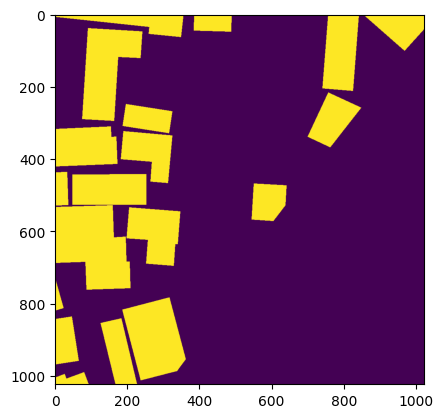

In [6]:
x, y = b
plt.imshow(y[0])

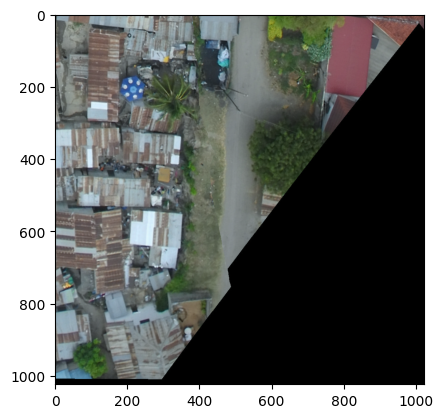

In [7]:
plt.imshow(deaugment_image(x[0]))

In [8]:
CLASSES = ["roof"]
ACTIVATION = None  # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = "cuda"

model = DinoSegmentor("dinov3", num_classes=len(CLASSES), device=DEVICE)

Backbone weights frozen: True


In [9]:
model = SegmentationModel(
    model=model,
    loss_fn=torch.nn.BCEWithLogitsLoss(),
    device=DEVICE,
)

In [10]:
# trainer = L.Trainer()
trainer = L.Trainer(
    precision="16",
    max_epochs=10,
    callbacks=[SaveStateDictCallback(save_dir="dinov3", prefix="dinov3_epoch")],
)

/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/main_11/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip 

In [11]:
# trainer.fit(model, tier1_dm)

In [ ]:
from pathlib import Path
import pandas as pd


def get_metrics(model_folder):
    metrics_log = []
    for model_pt in Path(model_folder).glob("*.pth"):
        model.model.head.load_state_dict(torch.load(model_pt))
        metrics = trainer.validate(model, tier1_dm)[0]
        metrics["model"] = model_pt.stem
        metrics_log.append(metrics)
    metrics_df = pd.DataFrame(metrics_log)
    metrics_df.to_csv(Path(model_folder) / "metrics.csv")
    return metrics_df


metrics_df = get_metrics("dinov3")

You are using a CUDA device ('NVIDIA GeForce RTX 5090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7459824681282043     │
│       val_iou_epoch       │    0.6175879240036011     │
│         val_loss          │    0.14336338639259338    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7605071663856506     │
│       val_iou_epoch       │    0.6341062784194946     │
│         val_loss          │    0.13780508935451508    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_f1_epoch        │    0.7640664577484131     │
│       val_iou_epoch       │    0.6399251818656921     │
│         val_loss          │    0.1358695924282074     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

In [ ]:
456 * 8